In [834]:
import warnings
warnings.filterwarnings('ignore')

# Import libraries for data processing and analyzing
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
# Import libraries for data visulization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

def remove_unw2anted(str):
    str = ''.join([c for c in str if c in 'ABCDEFGHIJKLNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz1234567890\''])
    return str

def clean_sentence(s):
    lst = [word for word in s.split()]

    lst_cleaned = []
    for items in lst:
        lst_cleaned.append(remove_unw2anted(items))
    return ' '.join(lst_cleaned)

%matplotlib inline

[nltk_data] Downloading package stopwords to /Users/roy/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [952]:
# there are three datasets needed to be imported For Seattle Airbnb Data
calendar = pd.read_csv('airbnb/seattle/calendar.csv')
listings = pd.read_csv('airbnb/seattle/listings.csv')
reviews = pd.read_csv('airbnb/seattle/reviews.csv')

In [950]:
display(calendar.info())
display(listings.info())
display(reviews.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 5 columns):
listing_id       1393570 non-null int64
date             1393570 non-null datetime64[ns]
available        1393570 non-null int64
price            934542 non-null object
price_numeric    1358895 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 53.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 93 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
listing_id       84849 non-null int64
id               84849 non-null int64
date             84849 non-null object
reviewer_id      84849 non-null int64
reviewer_name    84849 non-null object
comments         84831 non-null object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


None

In [731]:
listings['listing_id'] = listings['id']
calendar_full_columns = calendar.merge(listings,on='listing_id')

In [1039]:
# Import calendar.csv and data preprocessing 

calendar = pd.read_csv('airbnb/seattle/calendar.csv')
display(calendar.info())
calendar['available'] = calendar['available'].astype(np.str)
calendar['full'] = calendar['available'].map(lambda x: 1 if x=='f' else 0)
calendar['price_numeric'] = calendar['price'].map(lambda x: str(x)[1:].replace(',','') if x is not np.nan else x).astype(np.float)
calendar['price_numeric'] = calendar.groupby(by='listing_id')['price_numeric'].apply(lambda x:x.fillna(x.mean()))
calendar.dropna(subset=['price_numeric'],inplace=True)
calendar['revenue'] = calendar['price_numeric']*calendar['full']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null object
available     1393570 non-null object
price         934542 non-null object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


None

,id,reviews_per_month
2,3308979,1.15
22,8942678,0.86
356,5128160,0.79
432,1747184,1.29
1189,10136155,NaN
1298,9497431,NaN
2515,8036620,1.20
2906,9252998,NaN
3577,6066570,0.16
3618,9023202,NaN


,full,price_numeric,revenue,avg
listing_id,,,,
3308979,145,475163.636364,188763.636364,1301.818182
6066570,329,198925.000000,179305.000000,545.000000
9497431,230,274866.629630,173203.629630,753.059259
10136155,320,175200.000000,153600.000000,480.000000
8036620,289,193161.842105,152941.842105,529.210526
9023202,316,163885.000000,141884.000000,449.000000
8942678,312,164250.000000,140400.000000,450.000000
9252998,327,146000.000000,130800.000000,400.000000
1747184,244,195259.917355,130529.917355,534.958678


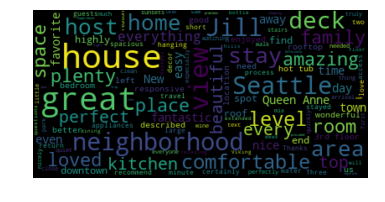

,word,counters
150,house,22
46,great,20
244,Jill,11
118,deck,10
23,neighborhood,10
22,Seattle,10
388,host,7
206,comfortable,7
401,area,7
67,would,6


In [1029]:
# find out the top revenue properties and check the reviews correlation

top_10_bnb = calendar.groupby('listing_id').sum().sort_values(by=['revenue'],ascending=False)[:10]
top_10_bnb_reviews = reviews[reviews.listing_id.isin(top_10_bnb.index.tolist())]
top_10_bnb_last_reviews = listings[listings.id.isin(top_10_bnb.index.tolist())][['id','reviews_per_month']]
display(top_10_bnb_last_reviews)
reviews_words = reviews[reviews.listing_id.isin([top_10_bnb.index.tolist()[0]])]
top_10_bnb['avg'] = top_10_bnb['revenue']/top_10_bnb['full']
#display(reviews.groupby('reviewer_id').size().loc[reviews_words.reviewer_id.values])
display(top_10_bnb)
whole_words = []
for s in reviews_words['comments'].values:
    whole_words.append(''.join(clean_sentence(s)))

common_words=['I','The','us','We','stay']
stop = set(stopwords.words('english'))
stop.update(common_words)
words = [word for word in ''.join(whole_words).split() if word not in stop]
words_freq = Counter(words)
wordcloud = WordCloud(max_font_size=40).generate(''.join(whole_words))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
display(pd.DataFrame(list(words_freq.iteritems()),columns=['word','counters']).sort_values(by=['counters'],ascending=False)[:10])

#calendar[calendar.listing_id.isin([top_10_bnb[1]])]['price_numeric'].hist()

listing_id
208356    474
365550    466
25002     404
47196     353
63308     320
92835     319
5682      297
279063    294
53867     287
841049    279
dtype: int64


,id,reviews_per_month
1441,365550,10.12
1447,208356,8.98
1499,92835,5.68
2166,5682,4.21
2456,53867,4.52
2568,63308,5.20
2668,841049,7.59
2690,279063,6.06
3083,25002,5.82
3600,47196,5.44


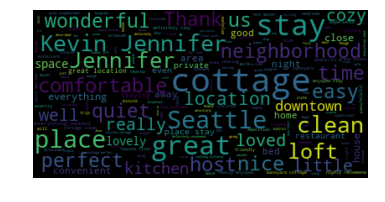

,word,counters
1093,cottage,216
1774,great,127
790,place,125
1780,Jennifer,105
1431,clean,103
612,Kevin,91
1747,Seattle,88
1003,It,81
73,would,79
1865,perfect,75


,listing_id,full,price_numeric,revenue,avg
554,53867,345,34529.000000,32637.000000,94.600000
1684,63308,91,35702.062044,8901.062044,97.813869
2006,365550,44,37514.267913,4522.267913,102.778816
2009,25002,57,28500.811688,4450.811688,78.084416
2154,5682,56,19689.919094,3020.919094,53.944984
2207,208356,25,37479.058824,2567.058824,102.682353
2393,92835,14,45867.293447,1759.293447,125.663818
2549,47196,17,24752.873563,1152.873563,67.816092
2884,841049,5,21170.000000,290.000000,58.000000
3013,279063,1,31226.552198,85.552198,85.552198


In [1030]:
# Check the top 10 most reviews properties and their revenue

top_10_review_bnb=reviews.groupby('listing_id').size().sort_values(ascending=False)[:10]
print top_10_review_bnb

top_10_review_last_reviews = listings[listings.id.isin(top_10_review_bnb.index.tolist())][['id','reviews_per_month']]
display(top_10_review_last_reviews)
whole_words = []
for s in reviews[reviews.listing_id.isin([top_10_review_bnb.index.tolist()[8]])]['comments'].values:
    whole_words.append(''.join(clean_sentence(s)))

common_words=['I','The','us','We','stay']
stop = set(stopwords.words('english'))
stop.update(common_words)
words = [word for word in ''.join(whole_words).split() if word not in stop]
words_freq = Counter(words)
wordcloud = WordCloud(max_font_size=40).generate(''.join(whole_words))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
display(pd.DataFrame(list(words_freq.iteritems()),columns=['word','counters']).sort_values(by=['counters'],ascending=False)[:10])

top_revenue_bnb = calendar.groupby('listing_id').sum().sort_values(by=['revenue'],ascending=False).reset_index()
top_revenue_bnb['avg'] = top_revenue_bnb['revenue']/top_revenue_bnb['full']
top_revenue_bnb[top_revenue_bnb['listing_id'].isin(top_10_review_bnb.index.tolist())]

In [37]:
reviews_list_id_grp_desc=reviews.groupby(by='listing_id').describe()['id'].sort_values(by='count',ascending=False)

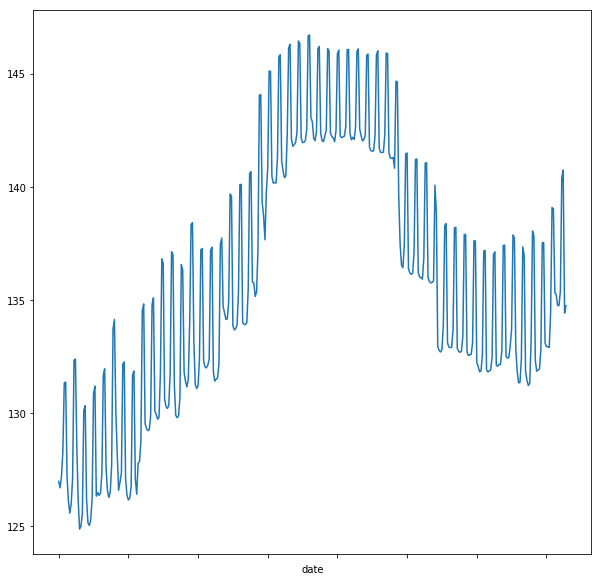

In [963]:
# Plot the average price along a year.
_,ax = plt.subplots(figsize=(10,10)) 
calendar_clean.groupby(by='date').mean()['price_numeric'].plot(ax=ax)

In [114]:
calendar['available'] = calendar['available'].astype(np.str)

In [179]:
full_date.index = pd.to_datetime(full_date.index, format='%Y-%m-%d')

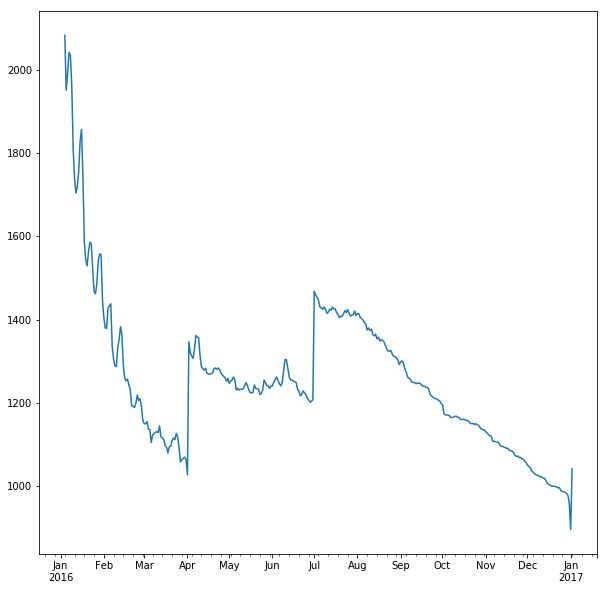

In [708]:
# plot the availability along a year
full_date.plot(figsize=(10,10))

In [207]:
calendar_available_ = calendar[calendar.available=='t'].groupby('listing_id').describe()['price_numeric'].sort_values(by='count')

In [195]:
listings['listing_id'] = listings['id']

In [281]:
calendar_available_  = calendar[calendar.available=='t'].groupby('listing_id').describe()['price_numeric'].sort_values(by='count')

In [300]:
listing_join_available = listings.join(calendar_available_)

In [283]:
listing_join_available['available'] = listing_join_available['count']

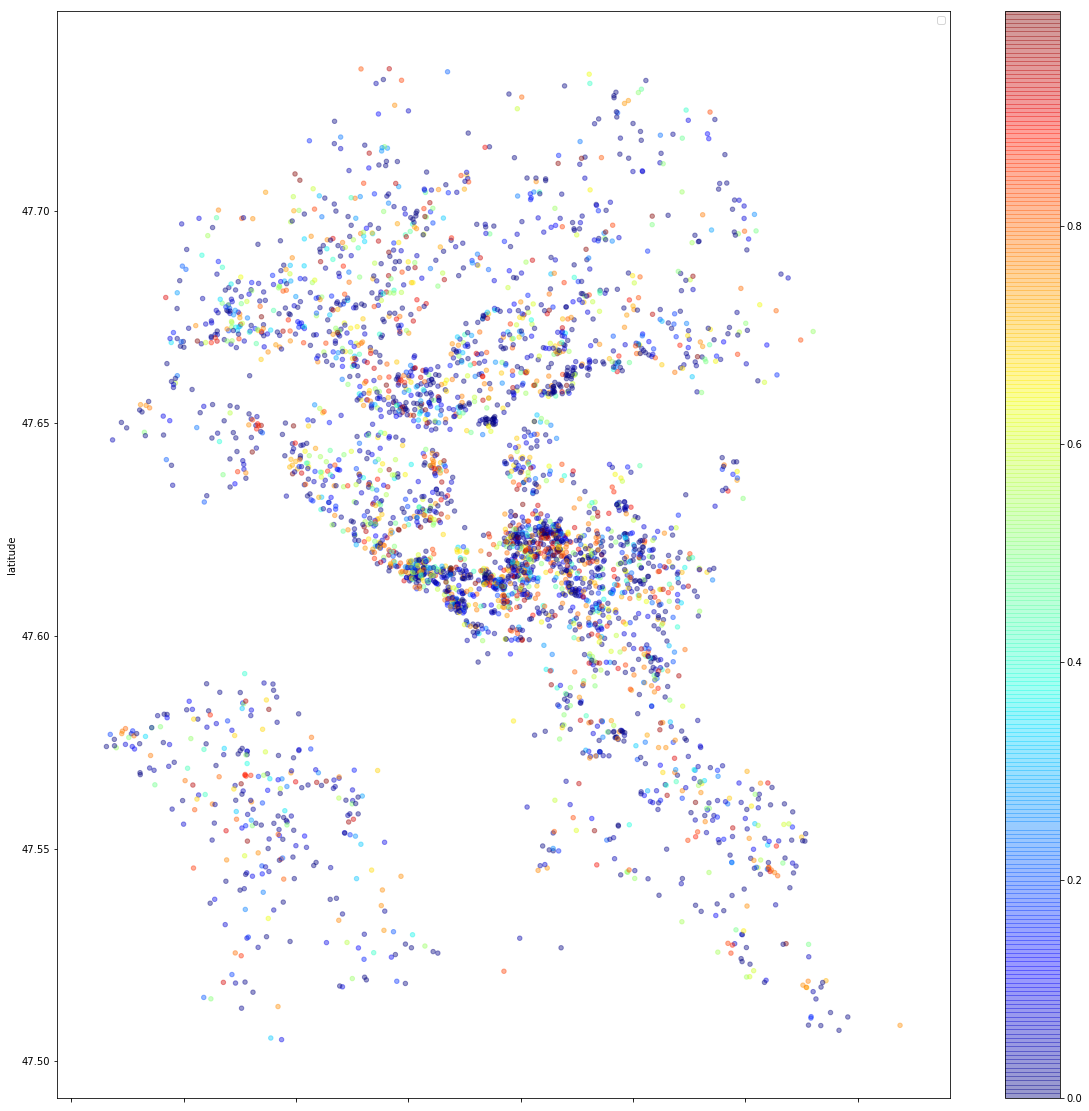

In [245]:
# plot the distribution of properties and availibility as color map
listing_join_available.plot(kind="scatter",x="longitude",y="latitude",alpha=0.4,c=1-(listing_join_available["available"]/365),cmap=plt.get_cmap("jet"),colorbar=True,figsize=(20,20))
plt.legend()

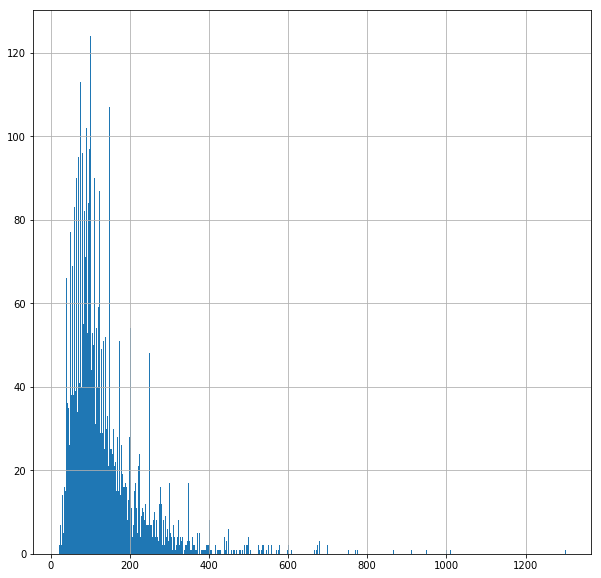

In [251]:
# plot the histogram price of all the properties
listing_join_available["mean"].hist(bins=500,figsize=(10,10))

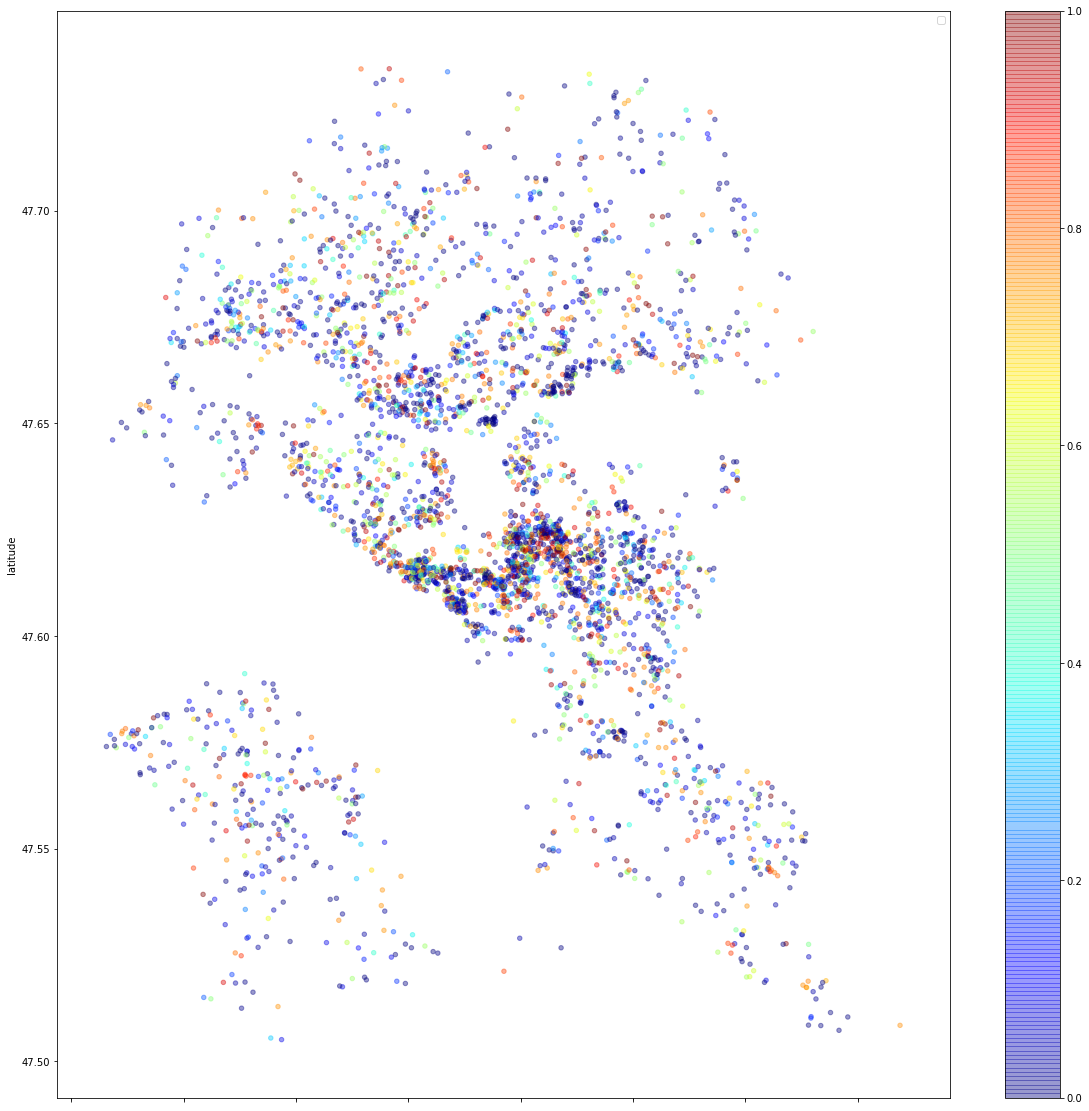

In [684]:
#listing_join_available['price'] = listing_join_available['price'].str.replace("[$, ]", "").astype("float")
listing_join_available.plot(kind="scatter",x="longitude",y="latitude",alpha=0.4,c=1-(listing_join_available["availability_365"]/365),cmap=plt.get_cmap("jet"),colorbar=True,figsize=(20,20))
plt.legend()

In [448]:
def clean_transform_category(df):
    new_df = df.copy()
    encoder = {}
    for col in new_df.select_dtypes(include=['object']).columns:
        new_df[col].fillna(new_df[col].mode()[0], inplace=True)
        encoder[col] = LabelEncoder()
        new_df[col] = encoder[col].fit_transform(new_df[col])
    
    return new_df,encoder

In [517]:
#listing_join_available['price'] = listing_join_available['price'].str.replace("[$, ]", "").astype("float")
listing_join_available_num = listing_join_available.select_dtypes(include=['int','float'])
not_useful_num_features = ['scrape_id','host_id','min','25%','50%','75%','max','mean','count','std']

In [305]:
listing_join_available_cat = listing_join_available.select_dtypes(include=['object'])

In [518]:
listing_join_available_num.drop(not_useful_num_features,axis=1,inplace=True)

In [306]:
listing_join_available_cat.columns

Index([u'listing_url', u'last_scraped', u'name', u'summary', u'space',
       u'description', u'experiences_offered', u'neighborhood_overview',
       u'notes', u'transit', u'thumbnail_url', u'medium_url', u'picture_url',
       u'xl_picture_url', u'host_url', u'host_name', u'host_since',
       u'host_location', u'host_about', u'host_response_time',
       u'host_response_rate', u'host_acceptance_rate', u'host_is_superhost',
       u'host_thumbnail_url', u'host_picture_url', u'host_neighbourhood',
       u'host_verifications', u'host_has_profile_pic',
       u'host_identity_verified', u'street', u'neighbourhood',
       u'neighbourhood_cleansed', u'neighbourhood_group_cleansed', u'city',
       u'state', u'zipcode', u'market', u'smart_location', u'country_code',
       u'country', u'is_location_exact', u'property_type', u'room_type',
       u'bed_type', u'amenities', u'price', u'weekly_price', u'monthly_price',
       u'security_deposit', u'cleaning_fee', u'extra_people',
       u'cal

In [519]:
bool_cat_features = ['host_is_superhost','instant_bookable','require_guest_profile_picture',
                           'require_guest_phone_verification','host_has_profile_pic','host_identity_verified',
                           'is_location_exact','requires_license']
limited_cat_features = ['host_response_rate','property_type','room_type','bed_type','cancellation_policy']

cat_features = bool_cat_features+limited_cat_features

In [520]:
listing_join_available_trans,encoder = clean_transform_category(listing_join_available[cat_features])


In [521]:
listing_join_available_clean = listing_join_available_num.join(listing_join_available_trans)

In [468]:
listing_join_available_clean.columns.tolist()

['id',
 'host_listings_count',
 'host_total_listings_count',
 'latitude',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'guests_included',
 'minimum_nights',
 'maximum_nights',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'calculated_host_listings_count',
 'reviews_per_month',
 'count',
 'mean',
 'std',
 'host_is_superhost',
 'instant_bookable',
 'require_guest_profile_picture',
 'require_guest_phone_verification',
 'host_has_profile_pic',
 'host_identity_verified',
 'is_location_exact',
 'requires_license',
 'host_response_rate',
 'property_type',
 'room_type',
 'bed_type',
 'cancellation_policy']

In [522]:
# clean up the data and preprocessing
from sklearn.tree import DecisionTreeRegressor
for column in listing_join_available_clean.columns:
    if listing_join_available_clean[column].count()/float(listing_join_available_clean.shape[0]) < 0.5:
        listing_join_available_clean.drop([column],axis=1,inplace=True)
    elif listing_join_available_clean[column].count()/float(listing_join_available_clean.shape[0]) < 1:
        if column in listing_join_available_num.columns:
            listing_join_available_clean[column].fillna(listing_join_available_clean[column].median(),inplace=True)
        else:
            listing_join_available_clean[column].fillna(listing_join_available_clean[column].mode()[0],inplace=True)
        
    
    

In [1023]:
listing_join_available_clean_revenue = listing_join_available_clean.merge(calendar.groupby('listing_id').sum().drop(['price_numeric'],axis=1),left_index=True,right_index=True)

(3054, 39)
(3054, 1)
Train RMSE 21.07
Test RMSE 54.38


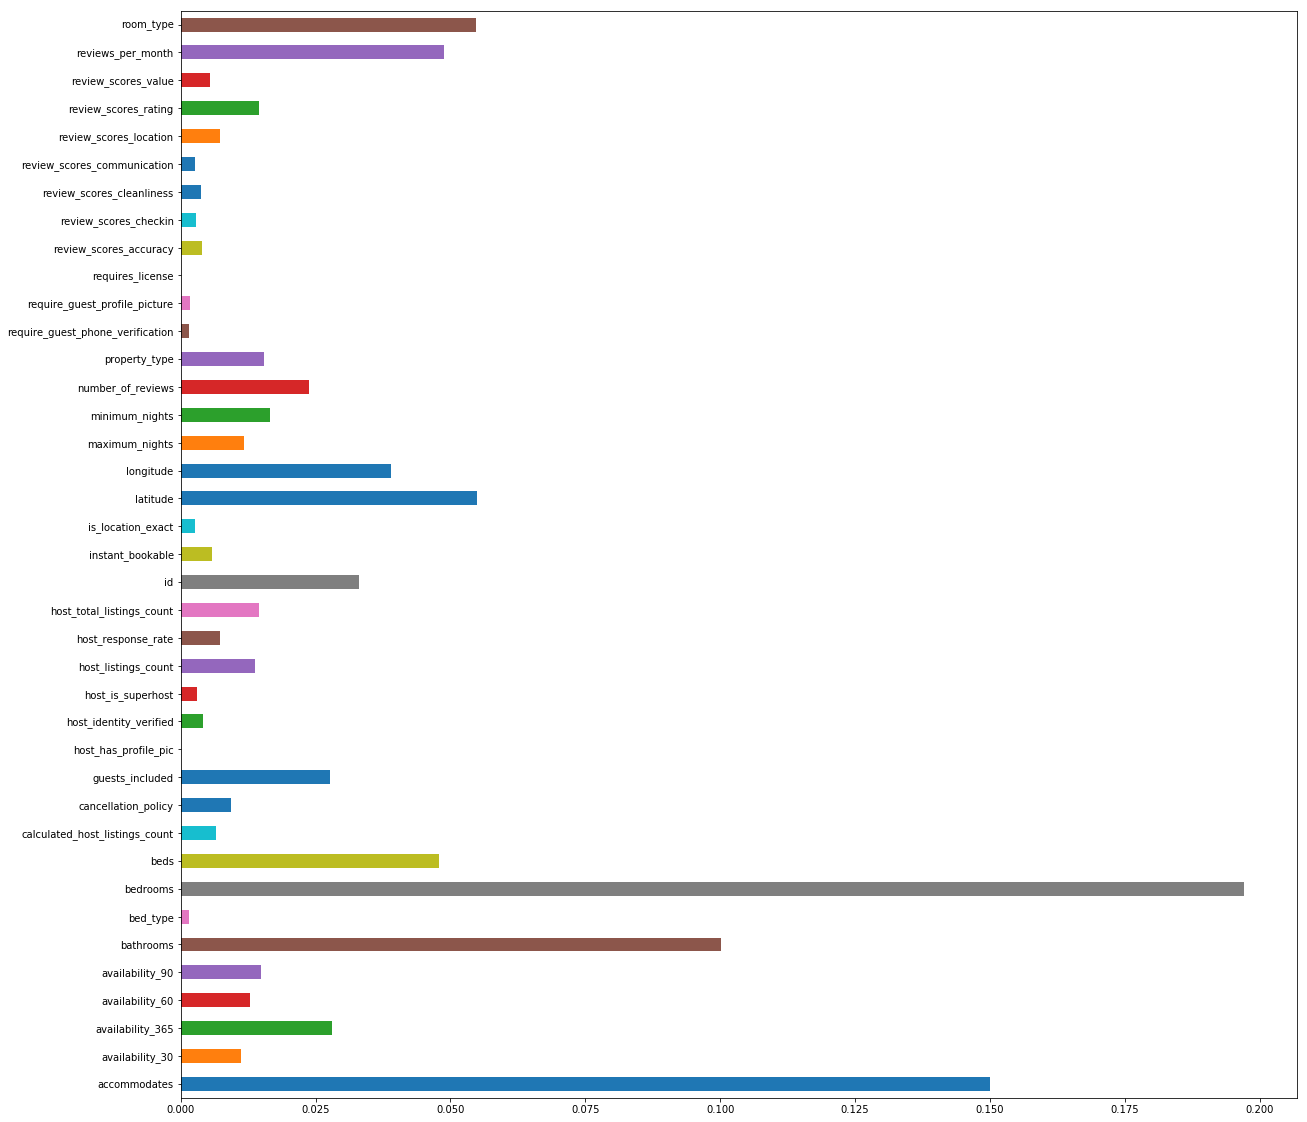

In [551]:
# Use RandomForestRegressor for predicting the price
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV



train_listing_join_available_clean = listing_join_available_clean.dropna(subset=['price'])

X_train,X_test,y_train,y_test = train_test_split(train_listing_join_available_clean.drop(['price'],axis=1),train_listing_join_available_clean[['price']], test_size=0.2, random_state=42)


param_grid = [{'n_estimators':[200],'max_features':[15]}]
print X_train.shape
print y_train.shape

forest_reg = RandomForestRegressor(n_estimators=200,max_features=15,random_state=42)

#grid_search = GridSearchCV(forest_reg,param_grid,cv=5,scoring='neg_mean_squared_error')
model = forest_reg.fit(X_train,y_train)
#model = grid_search.best_estimator_
prediction = model.predict(X_test)
tree_mse = mean_squared_error(y_test,prediction)
tree_rmse = np.sqrt(tree_mse)

train_prediction = model.predict(X_train)
train_tree_rmse = np.sqrt(mean_squared_error(y_train,train_prediction))
print "Train RMSE %.2f" % train_tree_rmse
print "Test RMSE %.2f" % tree_rmse

#print grid_search.best_params_

feature_importance = {}
for name,score in zip(X_train.columns,model.feature_importances_):
    feature_importance[name]=score

pd.Series(feature_importance).plot(kind='barh',figsize=(20,20))

(3054, 39)
(3054, 1)
Train RMSE 32.26
Test RMSE 85.73


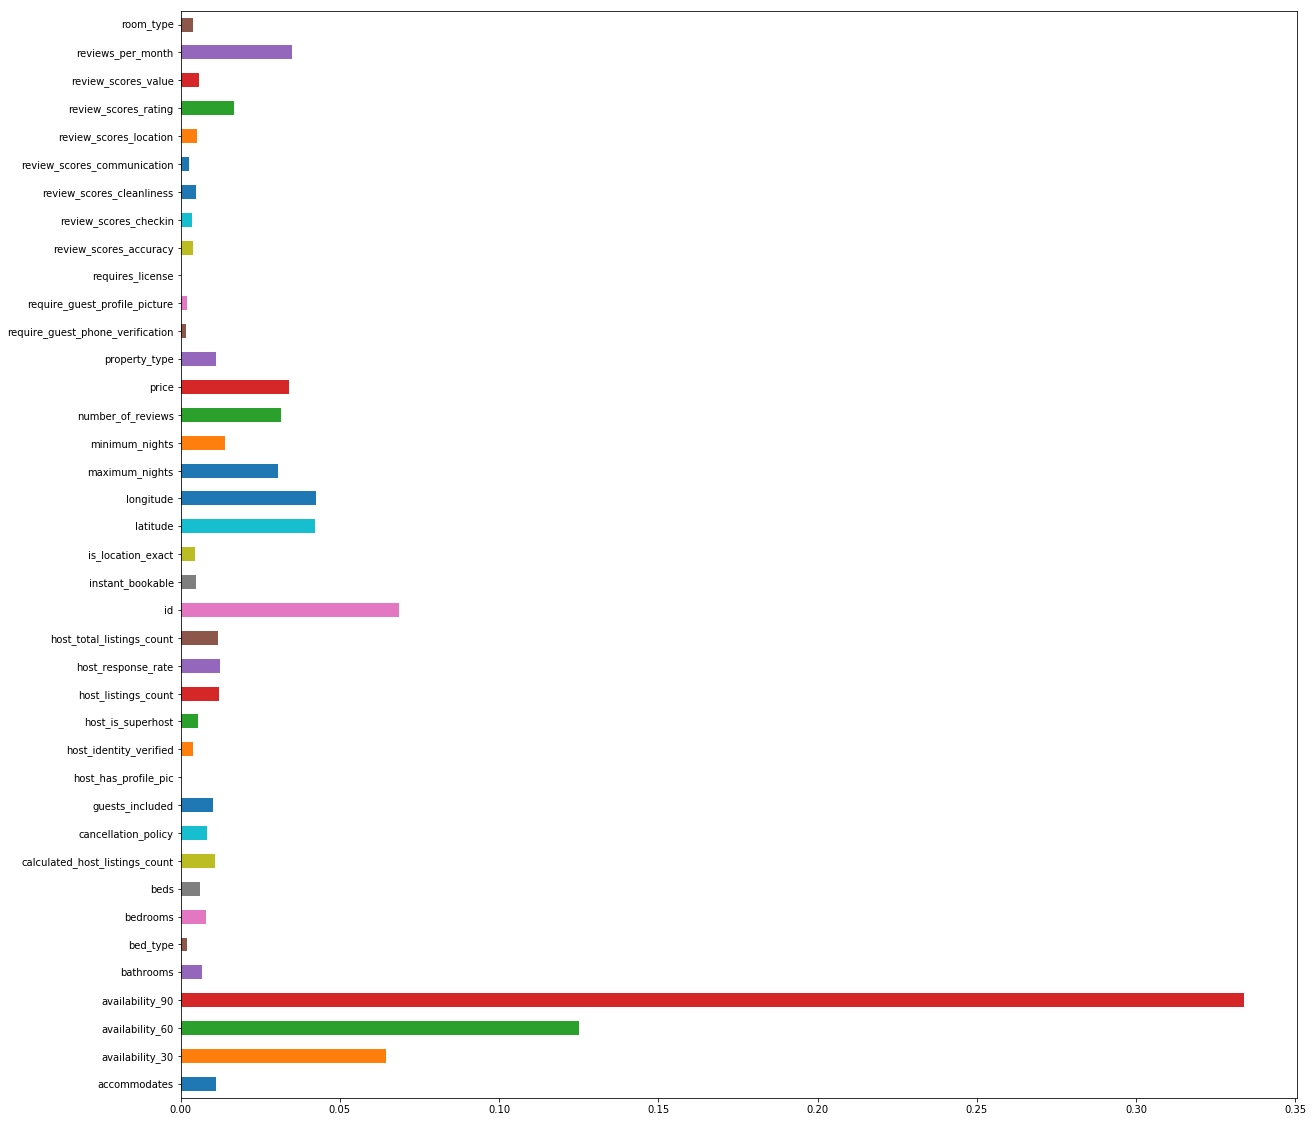

In [557]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV



train_listing_join_available_clean = listing_join_available_clean.dropna(subset=['price'])

X_train,X_test,y_train,y_test = train_test_split(train_listing_join_available_clean.drop(['availability_365'],axis=1),train_listing_join_available_clean[['availability_365']], test_size=0.2, random_state=42)


param_grid = [{'n_estimators':[150,200,300],'max_features':[15,20,30]}]
print X_train.shape
print y_train.shape

#forest_reg = RandomForestRegressor(n_estimators=200,max_features=15,random_state=42)

grid_search = GridSearchCV(forest_reg,param_grid,cv=5,scoring='neg_mean_squared_error')
grid_search = grid_search.fit(X_train,y_train)
model = grid_search.best_estimator_
prediction = model.predict(X_test)
tree_mse = mean_squared_error(y_test,prediction)
tree_rmse = np.sqrt(tree_mse)

train_prediction = model.predict(X_train)
train_tree_rmse = np.sqrt(mean_squared_error(y_train,train_prediction))
print "Train RMSE %.2f" % train_tree_rmse
print "Test RMSE %.2f" % tree_rmse

#print grid_search.best_params_

feature_importance = {}
for name,score in zip(X_train.columns,model.feature_importances_):
    feature_importance[name]=score

pd.Series(feature_importance).plot(kind='barh',figsize=(20,20))

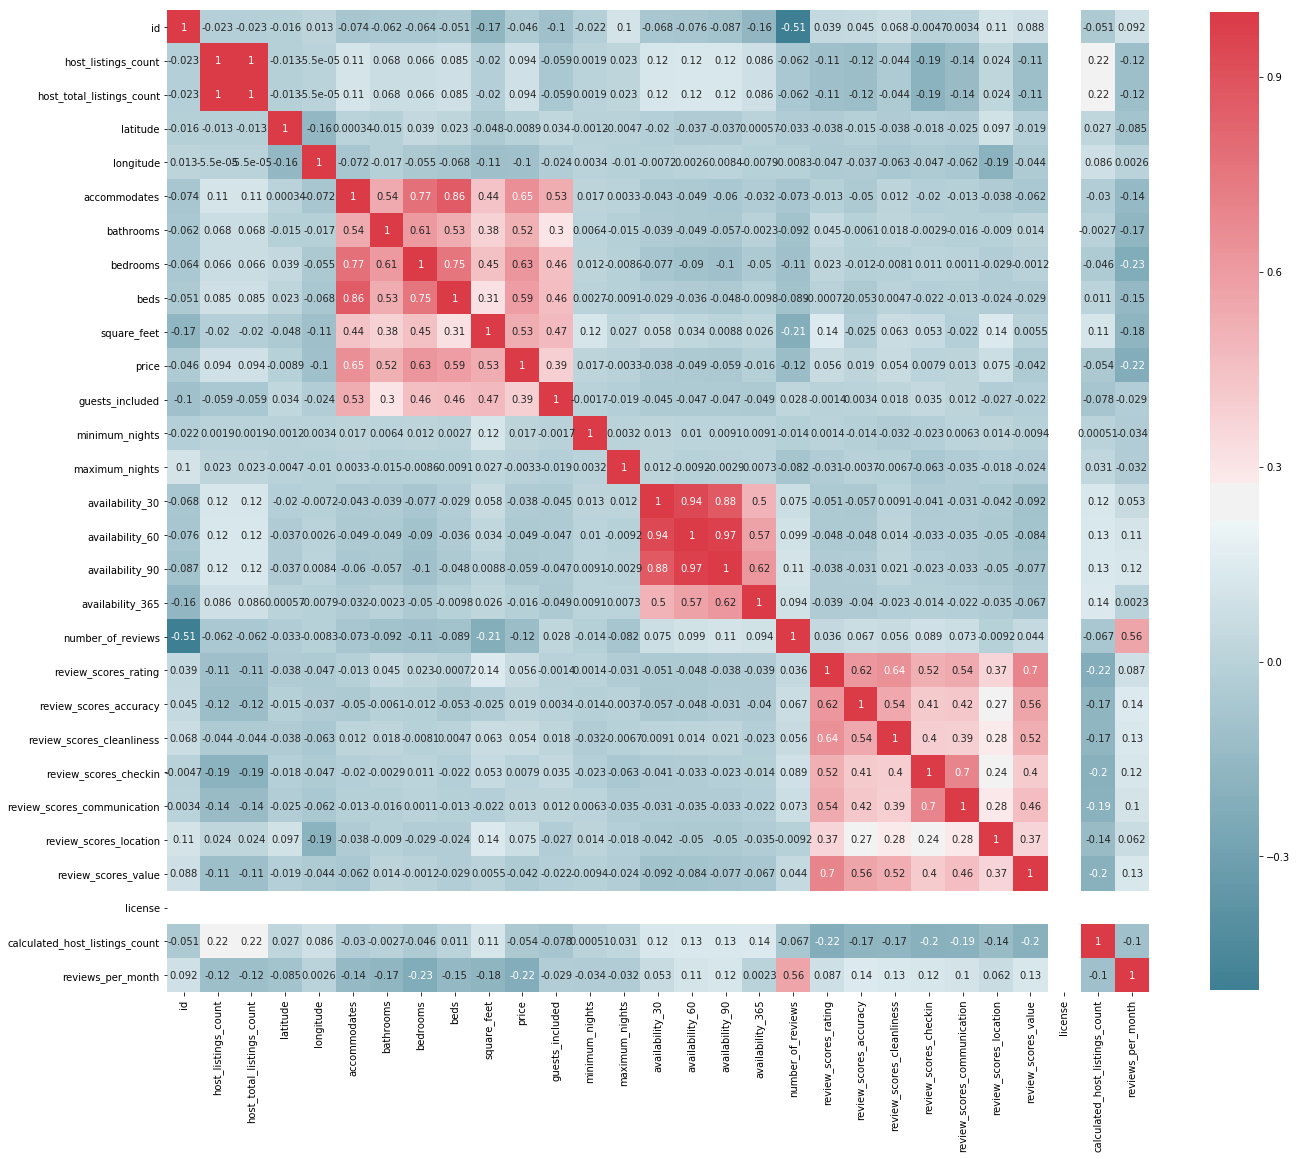

In [565]:
_ , ax = plt.subplots( figsize =( 22 , 20 ) )
cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
_ = sns.heatmap(
        listing_join_available_num.corr(), 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
    )



x, ['Apartment' 'Bed & Breakfast' 'Boat' 'Bungalow' 'Cabin' 'Camper/RV'
 'Chalet' 'Condominium' 'Dorm' 'House' 'Loft' 'Other' 'Tent' 'Townhouse'
 'Treehouse' 'Yurt']
hue, ['Entire home/apt' 'Private room' 'Shared room']


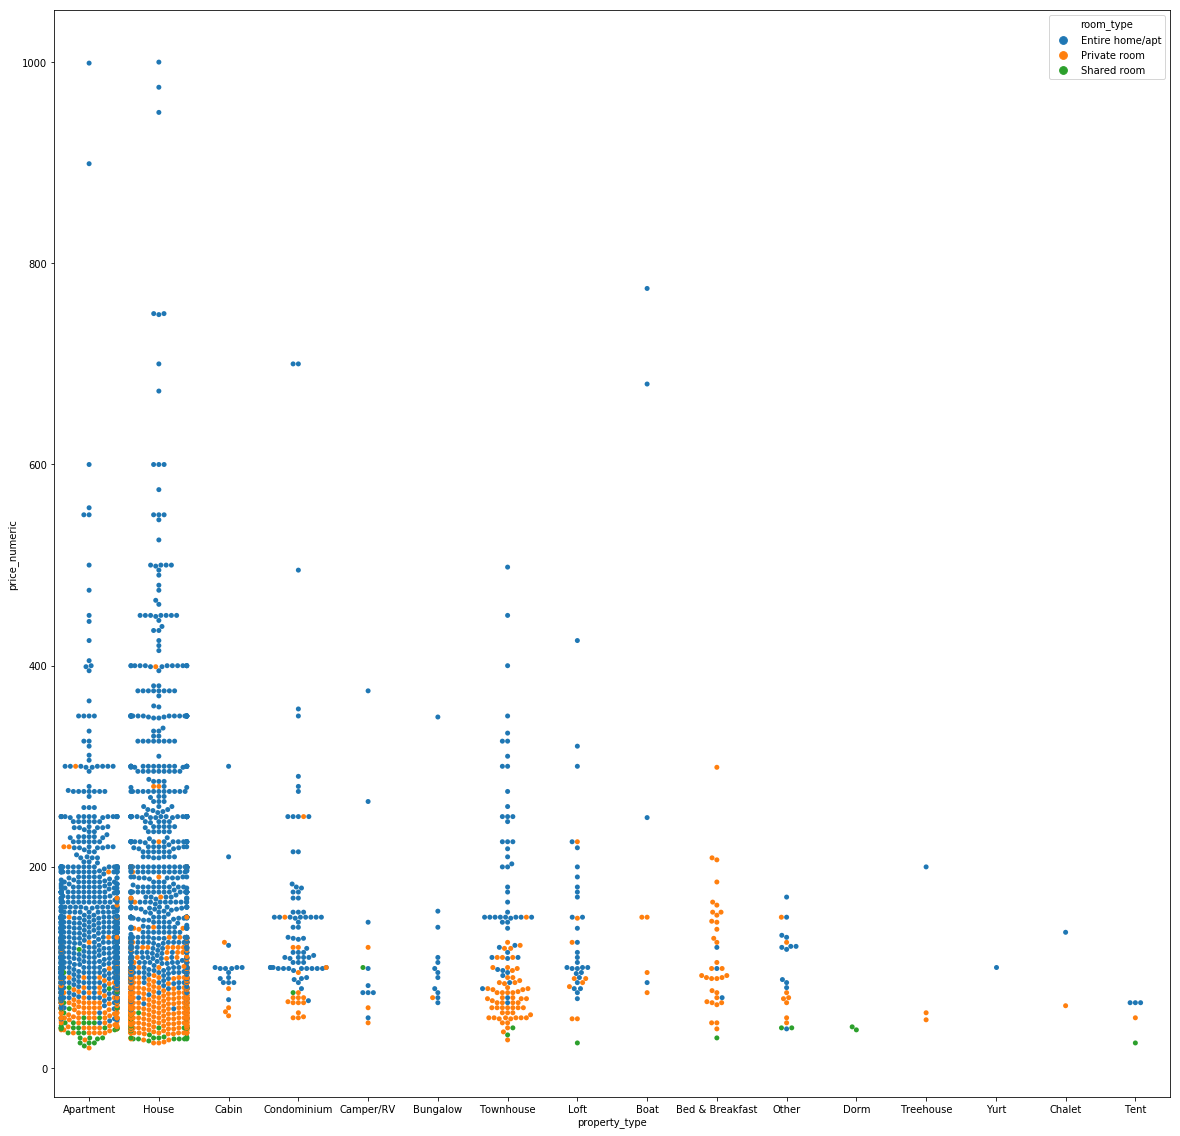

In [676]:
# Plot price distribution base on room type and property type
print 'x, %s' % encoder['property_type'].classes_
print 'hue, %s' % encoder['room_type'].classes_
listings['price_numeric'] = listings['price'].str.replace("[$, ]", "").astype("float")
_ , ax = plt.subplots( figsize =( 20 , 20 ) )
sns.swarmplot(x="property_type", y="price_numeric",hue='room_type', data=listings,ax=ax,);

In [656]:
cat_features

['host_is_superhost',
 'instant_bookable',
 'require_guest_profile_picture',
 'require_guest_phone_verification',
 'host_has_profile_pic',
 'host_identity_verified',
 'is_location_exact',
 'requires_license',
 'host_response_rate',
 'property_type',
 'room_type',
 'bed_type',
 'cancellation_policy']

(2978, 34)
(2978, 1)
Train RMSE 5.69
Test RMSE 3.29


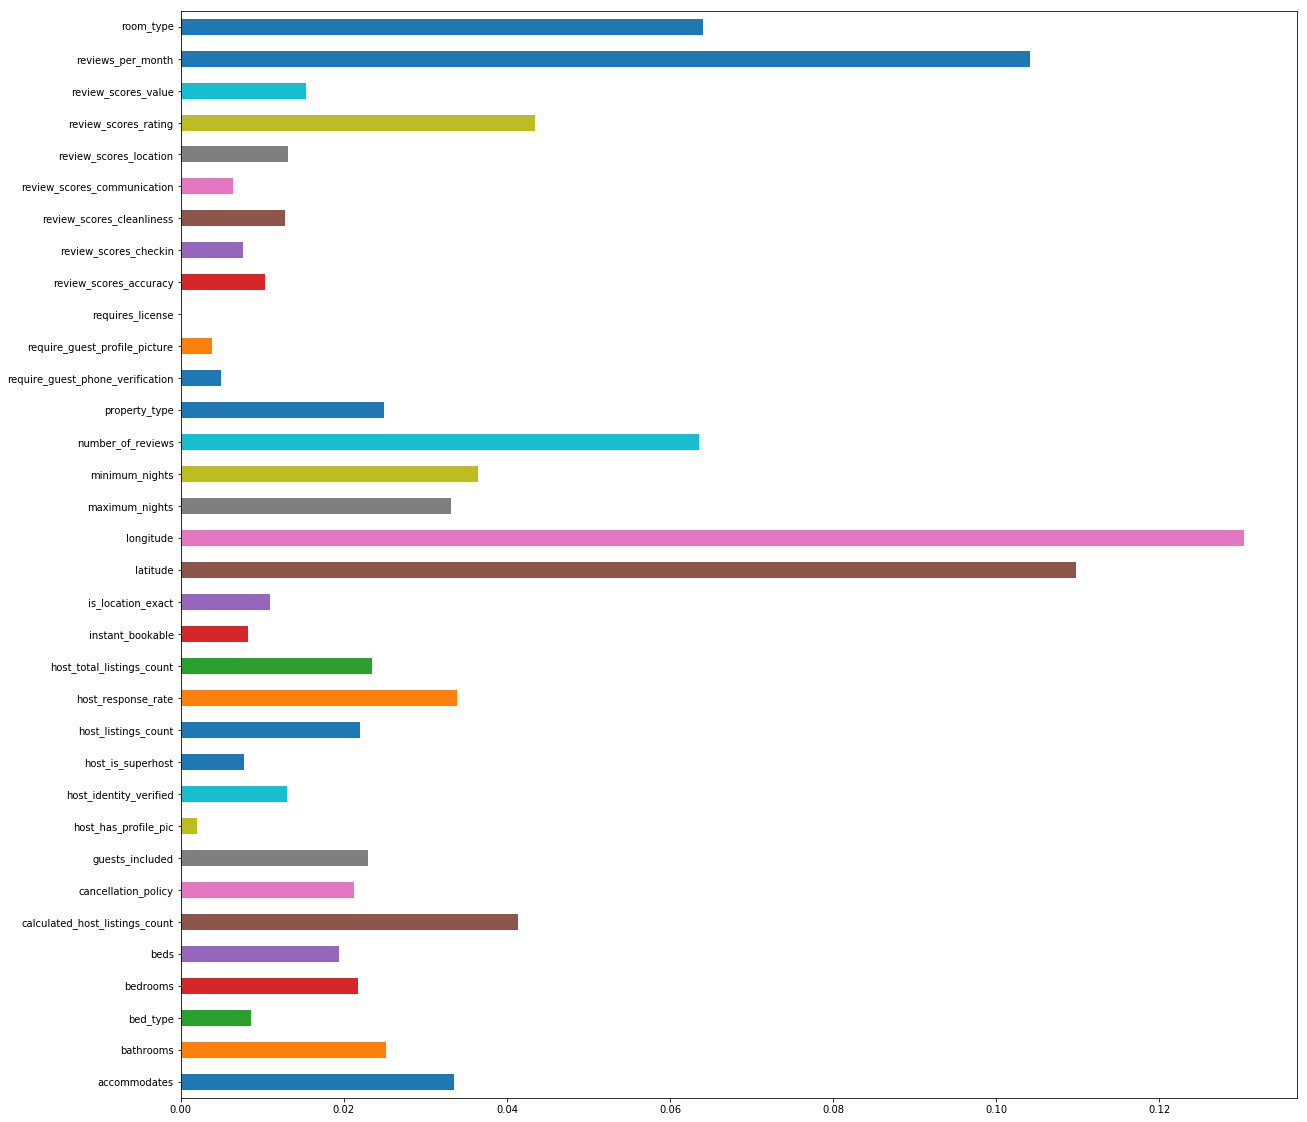

In [1028]:
# Predict the revenue by using RandomForestRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV



listing_join_available_clean_revenue = listing_join_available_clean_revenue.dropna(subset=['revenue']).drop(['id'],axis=1)

X_train,X_test,y_train,y_test = train_test_split(listing_join_available_clean_revenue.drop(['revenue'],axis=1),np.log1p(listing_join_available_clean_revenue[['revenue']]), test_size=0.2, random_state=42)


param_grid = [{'n_estimators':[300,400],'max_features':[15,20,30]}]
print X_train.shape
print y_train.shape

#forest_reg = RandomForestRegressor(n_estimators=200,max_features=15,random_state=42)

grid_search = GridSearchCV(forest_reg,param_grid,cv=5,scoring='neg_mean_squared_error')
grid_search = grid_search.fit(X_train,y_train)
model = grid_search.best_estimator_
prediction = model.predict(X_test)
tree_mse = mean_squared_error(y_test,prediction)
tree_rmse = np.sqrt(tree_mse)

train_prediction = model.predict(X_train)
train_tree_rmse = np.sqrt(mean_squared_error(np.log1p(y_train),train_prediction))
print "Train RMSE %.2f" % train_tree_rmse
print "Test RMSE %.2f" % tree_rmse

#print grid_search.best_params_

feature_importance = {}
for name,score in zip(X_train.columns,model.feature_importances_):
    feature_importance[name]=score

pd.Series(feature_importance).plot(kind='barh',figsize=(20,20))

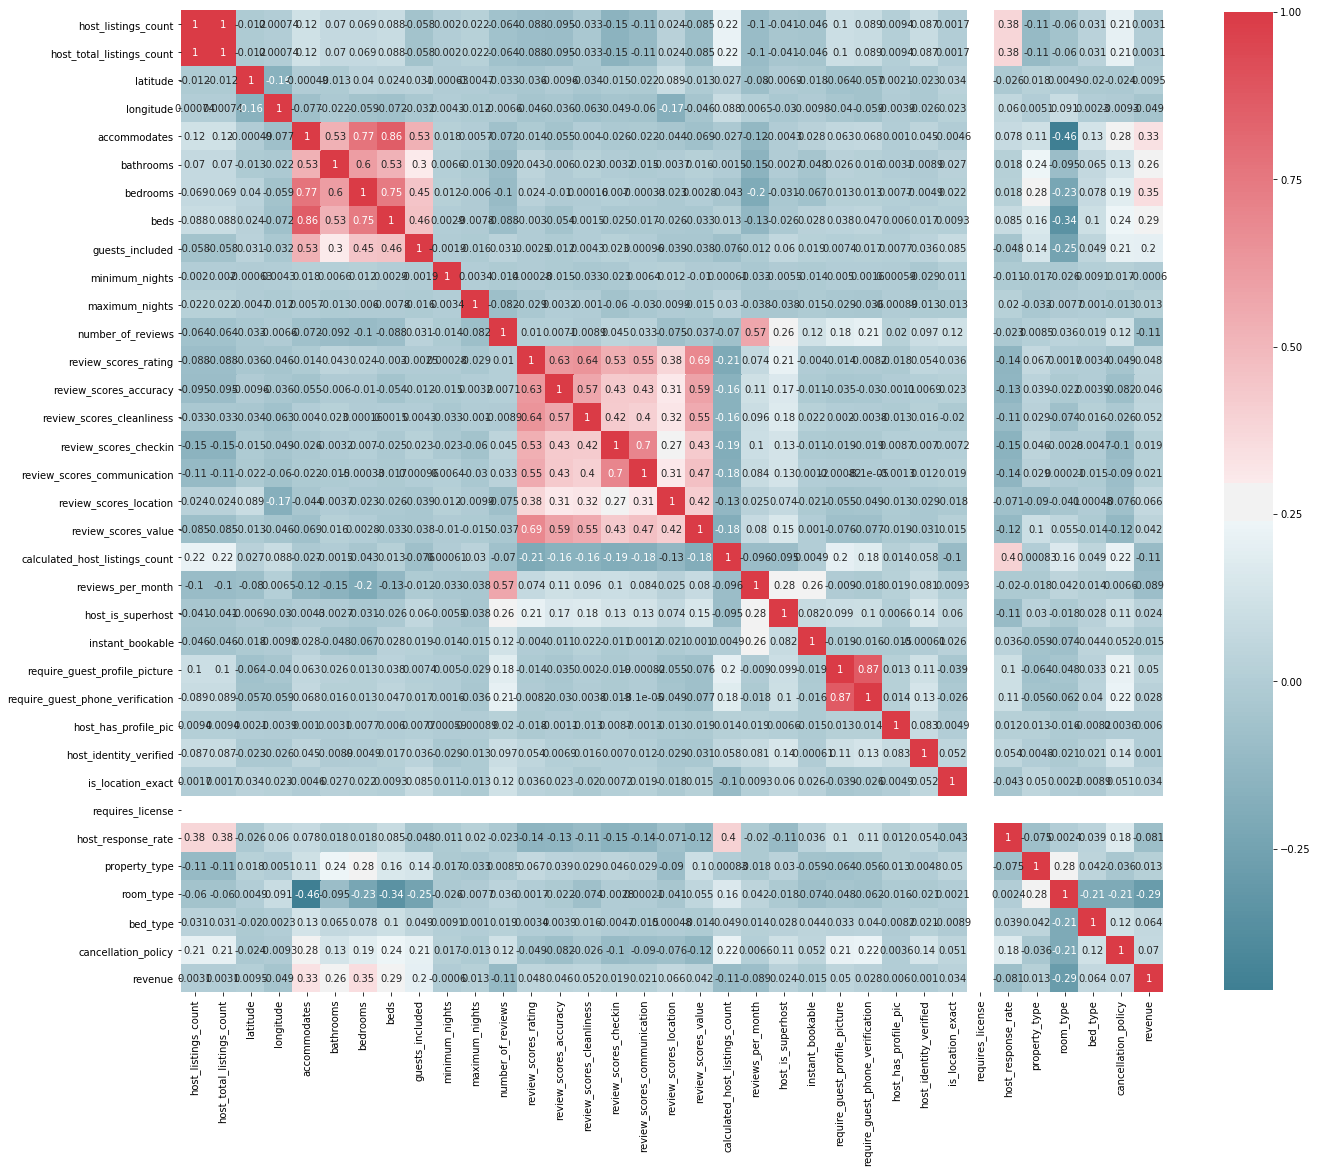

In [1036]:
_ , ax = plt.subplots( figsize =( 22 , 20 ) )
cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
_ = sns.heatmap(
        listing_join_available_clean_revenue.select_dtypes(include=['int','float']).corr(), 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
    )